# PyTorch Character Based LSTM Gender Classification

- Purpose: To classify gender of Japanese names
- Keywords: Character based classification, LSTM, PyTorch

In [1]:
import warnings
warnings.filterwarnings('ignore')

import glob
import unicodedata
import string
import random
import time
import math
import codecs

import torch
import torch.nn as nn
from torch.autograd import Variable

from sklearn.metrics import classification_report, accuracy_score

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [2]:
# ファイルを開いて一行ずつリストに格納する関数
def readLines(filename):
    """
    Read a file and store the lines into a list
    :param filename: single filename
    :return: list of lines in the file
    """
    lines = codecs.open(filename, 'r', 'utf-8').read().strip().split('\n')
    return lines

In [3]:
# 一行（名前一つに相当）をテンソルへ変換
def line_to_tensor(line):
    """
    Convert a line to a tensor (line_len x 1 x 57)
    :param line: line in string format
    :return: tensor in one hot vector
    >>> line
    >>> 'ツバサ'
    >>> tensor
    >>> (0 ,.,.) =
    >>> Columns 0 to 18
    >>>     1   0   0   0 ..
    >>> (1 ,.,.) =
    >>> Columns 0 to 18
    >>>     0   1   0   0 ..
    >>> (2 ,.,.) =
    >>> Columns 0 to 18
    >>>     0   0   1   0 ..
    >>> ...
    >>> Columns 38 to 84
    >>>     ... 0   0   0   0
    >>> [torch.FloatTensor of size 3x1x85]
    """
    all_letters = "ァアィイゥウェエォオカガキギクグケゲコゴサザシジスズセゼソゾタダチヂッツヅテデトド" \
                  "ナニヌネノハバパヒビピフブプヘベペホボポマミムメモャヤュユョヨラリルレロヮワヰヱヲンヴー"
    n_letters = len(all_letters)

    tensor = torch.zeros(len(line), 1, n_letters)  # n_letters=85
    for li, letter in enumerate(line):
        letter_index = all_letters.find(letter)
        tensor[li][0][letter_index] = 1
    return tensor


In [4]:
line_to_tensor('タロウ') #3(文字)x1x85(テンソル長)のテンソルが作られるはず


(0 ,.,.) = 

Columns 0 to 18 
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0

Columns 19 to 37 
    0   0   0   0   0   0   0   0   0   0   0   1   0   0   0   0   0   0   0

Columns 38 to 56 
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0

Columns 57 to 75 
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0

Columns 76 to 84 
    0   0   0   0   0   0   0   0   0

(1 ,.,.) = 

Columns 0 to 18 
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0

Columns 19 to 37 
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0

Columns 38 to 56 
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0

Columns 57 to 75 
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0

Columns 76 to 84 
    1   0   0   0   0   0   0   0   0

(2 ,.,.) = 

Columns 0 to 18 
    0   0   0   0   0   1   0   0   0   0   0   0   0  

In [5]:
# NNが推論した結果（テンソル）をカテゴリーデータへ戻す関数
def category_from_output(output):
    """
    Convert tensor output from NN model to cateory data
    :param output: output from NN model
    :return: category data
    >>> output
    >>> -0.2106 -1.6611
    >>> [torch.FloatTensor of size 1x2]
    >>>
    >>> top_n
    >>> -0.2106 [torch.FloatTensor of size 1x1] #=> -0.2106 > -1.6611
    >>> top_i
    >>> 0 [torch.LongTensor of size 1x1]
    >>> category_i
    >>> 0 [int]
    >>> all_categories[category_i]
    >>> 'boys_name'
    """
    top_n, top_i = output.data.topk(1) #Top1の値がtop_nに、インデックスがtop_iに格納される
    category_i = top_i[0][0]
    return all_categories[category_i], category_i


In [6]:
# LSTMクラス
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax()

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(1, self.hidden_size))


In [7]:
# 入力テンソル（line, category)を元に、モデルを訓練する関数
def train(category_tensor, line_tensor, model):
    """
    Perform training
    :param category_tensor: label tensor for input
    :param line_tensor: line tensor for input
    :param lstm: LSTM model instance
    :return: NN model output, loss
    """
    model.zero_grad()
    hidden = model.init_hidden()

    # Calculate loss
    for i in range(line_tensor.size()[0]):
        output, hidden = lstm(line_tensor[i], hidden)
    loss = criterion(output, category_tensor)  # nn.NLLLoss()

    # Calculate gradient
    loss.backward()

    # Performs a single optimization step including update of model parameters
    optimizer.step()

    return output, loss.data[0]

In [8]:
# 経過時間を取得する関数
def time_since(since):
    """
    Calculate processed time in min and sec
    :param since: time data when processing started
    :return: string to show min and sec
    """
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [9]:
# モデルを評価する関数
def evaluate(line_tensor, model):
    """
    Perform evaluation
    :param line_tensor: input tensor for evaluation
    :return: output from NN model
    """
    hidden = model.init_hidden()

    # Get prediction for all samples/lines
    for i in range(line_tensor.size()[0]):
        output, hidden = model(line_tensor[i], hidden)

    return output


In [10]:
# パラメータの初期化
category_lines = {}
all_categories = []
all_losses = []
n_hidden = 128
learning_rate = 0.005
n_epochs = 100000
print_every = 5000
plot_every = 1000
current_loss = 0

In [11]:
# 全ての名前を格納するリストcategory_linesを生成
# categoryはboys_nameまたはgirls_name
all_filenames = glob.glob('../data/jp_names/*.txt')
all_categories = []
for filename in all_filenames:
    category = filename.split('/')[-1].split('.')[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

In [12]:
category_lines['boys_name'][0:10]

['アキト', 'アキヒコ', 'アキヒロ', 'アキラ', 'アサヒ', 'アツキ', 'アツシ', 'アツヤ', 'アツロウ', 'アマネ']

In [13]:
# lstmモデル(LSTMクラスのインスタンス)を生成
n_letters = line_to_tensor('タロウ').shape[2]
n_categories = len(all_categories)
lstm = LSTM(n_letters, n_hidden, n_categories)  # 85, 128, 2

In [14]:
# 損失関数
criterion = nn.NLLLoss()

In [15]:
# 最適化関数
optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

In [16]:
# 訓練の実施
start = time.time()
for epoch in range(1, n_epochs + 1):
    # ランダムに入力データ及びそのカテゴリを取得し、テンソル化する
    category = random.choice(all_categories)
    line = random.choice(category_lines[category])
    category_tensor = Variable(torch.LongTensor([all_categories.index(category)]))
    line_tensor = Variable(line_to_tensor(line))

    # 現エポックでの訓練と損失計算
    output, loss = train(category_tensor, line_tensor, lstm)
    current_loss += loss

    # 訓練状況の表示 エポック数, 損失, 評価対象名前, 推論結果の表示
    if epoch % print_every == 0:
        guess, guess_i = category_from_output(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (
        epoch, epoch / n_epochs * 100, time_since(start), loss, line, guess, correct))
    # [例]
    # 10000 10% (0m 21s) 0.8611 カズマ / girls_name ✗ (boys_name)
    # 15000 15% (0m 31s) 0.0329 リョウマ / boys_name ✓
    # 20000 20% (0m 41s) 0.0103 ミナ / girls_name ✓
    
    # 平均損失をリストall_lossesへ格納
    if epoch % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0


5000 5% (0m 7s) 0.3699 レイナ / girls_name ✓
10000 10% (0m 15s) 0.3640 リクト / boys_name ✓
15000 15% (0m 23s) 0.1628 アヤネ / girls_name ✓
20000 20% (0m 30s) 0.5114 トカチ / boys_name ✓
25000 25% (0m 38s) 0.0055 オウスケ / boys_name ✓
30000 30% (0m 46s) 0.0000 ショウタロウ / boys_name ✓
35000 35% (0m 53s) 0.7279 ヒロ / girls_name ✗ (boys_name)
40000 40% (1m 1s) 0.0308 メグミ / girls_name ✓
45000 45% (1m 8s) 0.1221 ミズホ / girls_name ✓
50000 50% (1m 16s) 0.0001 ケイタツ / boys_name ✓
55000 55% (1m 24s) 2.6564 カイ / girls_name ✗ (boys_name)
60000 60% (1m 31s) 0.0542 シホ / girls_name ✓
65000 65% (1m 39s) 0.1307 アカリ / girls_name ✓
70000 70% (1m 47s) 0.3581 ユウリ / boys_name ✓
75000 75% (1m 54s) 0.0688 リョウコ / girls_name ✓
80000 80% (2m 2s) 0.0152 レイカ / girls_name ✓
85000 85% (2m 9s) 0.0156 ソウマ / boys_name ✓
90000 90% (2m 17s) 1.2707 ユタカ / girls_name ✗ (boys_name)
95000 95% (2m 25s) 0.0384 ツカサ / boys_name ✓
100000 100% (2m 33s) 0.2775 スズネ / girls_name ✓


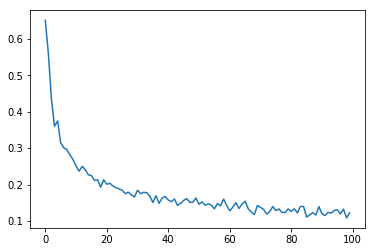

In [17]:
# Plot loss
plt.figure()
plt.plot(all_losses)

In [18]:
# 混合行列の初期化
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

In [19]:
# 評価の実施と混合行列への値格納
for i in range(n_confusion):
    # ランダムに入力データ及びそのカテゴリを取得し、テンソル化する
    category = random.choice(all_categories)
    line = random.choice(category_lines[category])
    category_tensor = Variable(torch.LongTensor([all_categories.index(category)]))
    line_tensor = Variable(line_to_tensor(line))

    # 評価
    output = evaluate(line_tensor, lstm)
    
    # 推論結果（テンソル）の値とインデックスを取得
    guess, guess_i = category_from_output(output)
    
    # 正解カテゴリインデックスをcategoryから取得
    category_i = all_categories.index(category)
    
    # 混合行列への値格納
    confusion[category_i][guess_i] += 1

In [20]:
# 混合行列の正規化
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

In [21]:
all_categories

['boys_name', 'girls_name']

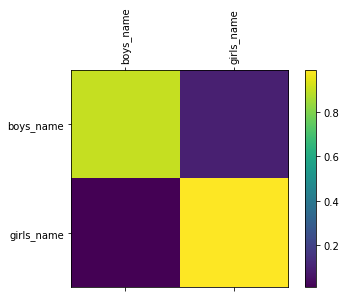

In [22]:
# 混合行列の描画
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

In [23]:
# モデルで推論する関数
def predict(input_line, n_predictions=2):
    """
    Perform prediction
    :param input_line: input tensor for prediction
    :param n_predictions: number of data to generate from one sample
    :return: prediction result
    >>> input_line
    >>> サトシ
    >>>(-0.05) boys_name
    >>>(-2.97) girls_name
    """
    hidden = lstm.init_hidden()
    var_line = Variable(line_to_tensor(input_line))

    # Get prediction for all samples/lines
    for i in range(var_line.size()[0]):
        output, hidden = lstm(var_line[i], hidden)

    # Get top N categories (probability, category_index)
    topv, topi = output.data.topk(n_predictions, 1, True)

    # Store prediction result to a patent
    predictions = []
    print('\n> %s' % input_line)
    for i in range(n_predictions):
        value = topv[0][i]
        category_index = topi[0][i]
        print('(%.2f) %s' % (value, all_categories[category_index]))
        predictions.append([value, all_categories[category_index]])

In [24]:
# テスト1
predict('サトシ')


> サトシ
(-0.21) boys_name
(-1.66) girls_name


In [25]:
# テスト2
predict('クミコ')


> クミコ
(-0.00) girls_name
(-10.20) boys_name
